# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

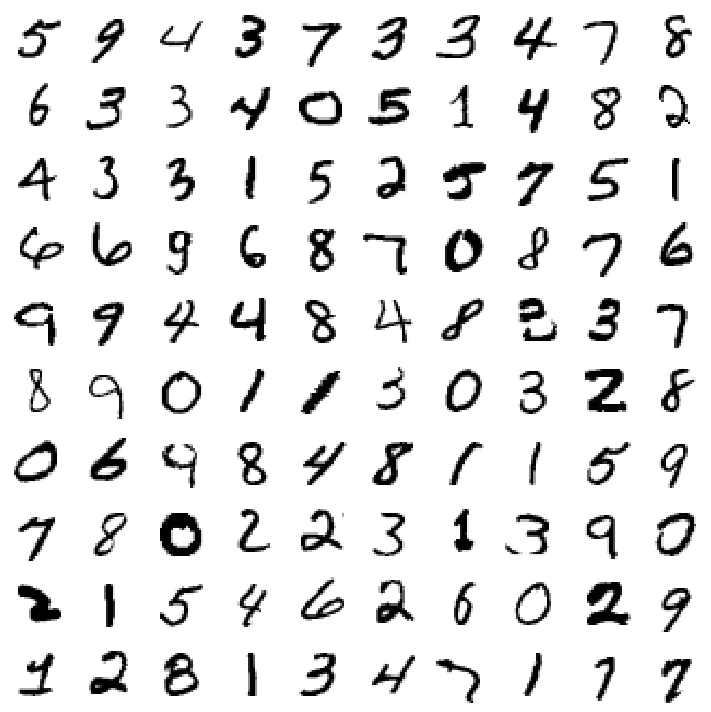

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Compile and train the network (note that this could take a while).

In [ ]:
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

In [1]:
# Import libraries and functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

In [2]:
# Enter the location of the DRIVE dataset
data_folder = 'C:/Users/20182104/Documents/TUe/Jaar 4/Machine Learning/8DM50_Group4/Assignment_week_4/DRIVE/'
#data_folder = 'C:/Users/20182834/Desktop/datasets/'
train_paths = glob(data_folder + 'training/images/*.tif')

In [4]:
# Change the pathnames so that all slashes they all are the same
train_paths_r = []

for i in train_paths:
    train_paths_r.append(i.replace("\\", "/"))

In [5]:
# Load the data and print the shape of the image dataset
images, masks, segmentations = load_data(train_paths_r)

print(images.shape)

(20, 584, 565, 3)


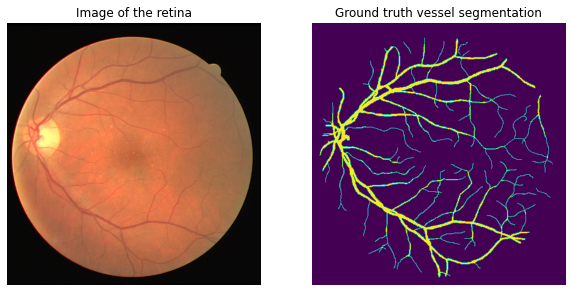

In [6]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

In [7]:
# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


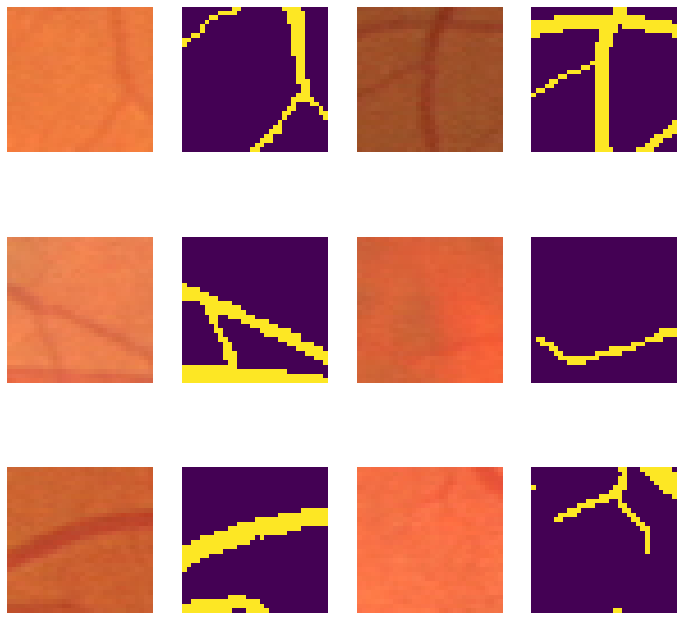

In [8]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [9]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [10]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 1 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history_no_aug = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

### Visualizing the segmentation results

In [12]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/20182834/Desktop/datasets/test/1st_manual\\01_manual1.gif'

# Exercises

## Number of parameters

***Not sure if we have to add this source line*** To answer the following questions the following sources have been used:
[source 1](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)
[source 2](https://theaisummer.com/skip-connections/)

<font color='#770a0a'>The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? </font>

Basically, the number of parameters in a given layer is the count of “learnable” (assuming such a word exists) elements for a filter aka parameters for the filter for that layer. Parameters in general are weights that are learnt during training. They are weight matrices that contribute to model’s predictive power, changed during back-propagation process.

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

Convolutional layer: To calculate the learnable parameters here, we need the shape of width m, height n, previous layer’s filters d and the number of filters k. The formula to calculate the number of parameters in a CONV layer is given by ((shape of width of the filter * shape of height of the filter * number of filters in the previous layer + 1)* number of filters). Where the term “filter” refers to the number of filters in the current layer and the 1 is added because of the bias term for each filter. A shorter way to write this expression is: ((m * n * d) + 1)* k). 

Fully Connected Layer (FC): This layer has the highest number of parameters in comparison to the other layers because, each neuron is connected to every other neuron. The number of paramters can be calculated by taking the product of the number of neurons in the current layer c and the number of neurons on the previous layer p. This results in: ((current layer neurons c * previous layer neurons p) + 1 * c), where 1 is added again because of the bias term for each filter. 

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Data is loaded")

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

print("Let's compute the model")

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (12, 12), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(10, (1, 1), activation='softmax'))
model.add(Flatten())
model.summary()

print("Yes, your model is now ready to be compiled")

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

print("We are now going to train the model")

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

print("Let's evaluate how well our model is doing predictions on the test data set.")

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

First we have to define skip connections. Skip connections skip one layer in the neural network. In a neural network without skip connections, the output of a layer is given as input in only the next layer. With the addition of skip connections, the output of a layer is fed to more layers following that layer. Adding skip connections to a U-Net neural network (U shaped so downsampling followed by upsampling) small details can be recovered in the prediction, information that was lost in the downsampling is recovered.  

Because the output is passed onto more layers it is possible to train the exact same architecture. Skip connections pass information that might get lost in deeper layers, this results in better preservation of details of the features, in biomedical imaging for example the edges, shapes or textures. 

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

With data augmentation, new training data is artificially created from the existing training data. This size of the training data set will be larger; new and different data is added. This results in better model performance, more generalization and thus less overfitting. 

There is no point in using data augmentation for the test set. Data augmentation is only for ensuring that the model gets more robust. The test data should be close to the real data, in order to know how it performs in real case scenarios. Using augmented data possibly paints a wrong picture of the performance of the model.

**Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above.** 


*__________________________________________________________________*

**WAT MOET ER NOG VERANDERD WORDEN / WAAR MOET NOG NAAR GEKEKEN WORDEN?**
* Nu wordt er per beeld in de training data set 2 nieuwe beelden gecreëerd voor de augmented dataset. Moet dit meer/minder worden?
* De history_no_aug (uit voorbeeld dat gegeven is hierboven) is om een of andere vage reden toegepast op alleen het eerste beeld uit de training set. Ik denk dat we een keuze moeten maken: of we passen alleen augmentation toe op het eerste beeld en vergelijken dan de resultaten, of we laten het zo staan (augmentation op alle beelden) en we moeten dan nog even het model trainen op de complete dataset zodat ook history_no_aug alle beelden bevat. 

__

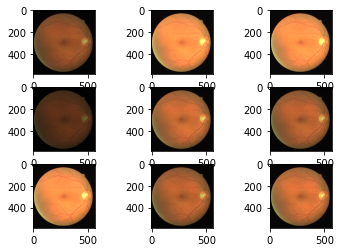

In [11]:
# SHOW THE EFFECT OF THE RANDOM BRIGHTNESS ALGORITHM ON THE IMAGES
from data_augmentation import show_data_aug_effect

show_data_aug_effect(train_images)

In [14]:
# CREATION OF AUGMENTED DATASET (ONLY BRIGHTNESS AUGMENTATION)
from data_augmentation import brightness_augmentation_data

nr_new_images = 2 # How many new images should be created per training image
range_brightness = [0.4,1.3]

train_X_aug, train_segmentations_aug, train_X_tot, train_segmentations_aug_tot = brightness_augmentation_data(train_images,train_segmentations,nr_new_images,range_brightness)

In [15]:
# Shapes of the augmentation data set
print('Shape of augmented data set: '+ str(train_X_aug.shape))
print('Shape of corresponding segmentations: ' + str(train_segmentations_aug.shape))

# Shapes of the total data set, 'normal' images and augmentation data
print('Shape of complete data set (real data + augmented data): ' + str(train_X_tot.shape))
print('Shape of corresponding segmentations: ' + str(train_segmentations_aug_tot.shape))

Shape of augmented data set: (32, 584, 565, 3)
Shape of corresponding segmentations: (32, 584, 565, 1)
Shape of complete data set (real data + augmented data): (48, 584, 565, 3)
Shape of corresponding segmentations: (48, 584, 565, 1)


In [17]:
# TRAINING OF THE MODEL WITH AUGMENTED DATA (ONLY BRIGHTNESS AUGMENTATION)

# Hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 3 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_X_tot)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## LET OP!! Hier wordt alle data gebruikt, niet een 'single training image' zoals in history_no_aug wordt gedaan. 
# train the model with the new data set (including augemented data) and save the training history
history_with_aug = model.fit(datagenerator(train_X_tot, train_segmentations_aug_tot, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/3
 - 256s - loss: 0.5056 - accuracy: 0.8331 - val_loss: 0.2808 - val_accuracy: 0.9211
Epoch 2/3
 - 210s - loss: 0.3100 - accuracy: 0.9030 - val_loss: 0.4532 - val_accuracy: 0.9211
Epoch 3/3
 - 213s - loss: 0.2921 - accuracy: 0.9029 - val_loss: 0.3682 - val_accuracy: 0.9211


In [21]:
# PLOTTING OF THE ACCURACY PER EPOCH FOR DATASET AND AUGMENTED DATASET

fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_no_aug.history['accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(history_no_aug.history['val_accuracy'],
         label='test accuracy',
         c='orange',ls='--')

plt.plot(history_with_aug.history['accuracy'],
         label='train accuracy augmented',
         c='dodgerblue', ls='-')
plt.plot(history_with_aug.history['val_accuracy'],
         label='test accuracy augmented',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

NameError: name 'history_no_aug' is not defined

<Figure size 432x288 with 0 Axes>

ADD EXPLANATION/CONCLUSION ABOUT PLOT ABOVE

**Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.**

In [20]:
import gryds

# Define a B-spline transformation object
bspline = gryds.BSplineTransformation(random_grid)

# Define an interpolator object for the image:
interpolator = gryds.Interpolator(image)

# Transform the image using the B-spline transformation
transformed_image = interpolator.transform(bspline)

NameError: name 'random_grid' is not defined

In [18]:
# CREATION OF AUGMENTED DATASET (BRIGHTNESS AND B-SPLINE GEOMETRIC AUGMENTATION)
from data_augmentation import brightness_bspline_augmentation_data

nr_new_images = 2 # How many new images should be created per training image
range_brightness = [0.4,1.3]

train_X_aug_bspline, train_segmentations_aug_bspline, train_X_bspline_tot, train_segmentations_aug_bspline_tot = brightness_bspline_augmentation_data(train_images,train_segmentations,nr_new_images,range_brightness)

ImportError: cannot import name 'brightness_bspline_augmentation_data'

In [ ]:
# TRAINING OF THE MODEL WITH AUGMENTED DATA (BRIGHTNESS AND B-SPLINE GEOMETRIC AUGMENTATION)

# Hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 3 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_X_bspline_tot)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## LET OP!! Hier wordt alle data gebruikt, niet een 'single training image' zoals in history_no_aug wordt gedaan. 
# train the model with the new data set (including augemented data) and save the training history
history_aug_bspline = model.fit(datagenerator(train_X_bpsline_tot, train_segmentations_aug_bspline_tot, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(history_history_aug_bspline.history['accuracy'],
         label='train accuracy augmented + b-spline',
         c='dodgerblue', ls='-')
plt.plot(history_history_aug_bspline.history['val_accuracy'],
         label='test accuracy augmented + b-spline',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

ADD EXPLANATION/CONCLUSION ABOUT PLOT ABOVE